In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.patches as mpatches

In [2]:
# resample a dataframe to how many slots there are per step_size
def resample_slots(data, step_size = '1D'):
    tmp = data.set_index('block_datetime', drop=True)
    return tmp.resample(step_size, origin=pd.to_datetime('2022-09-14')).count()['slot']

In [ ]:
base_path = '../data/'
file_paths = os.listdir(base_path)

dfs = []
for file in file_paths:
    if file == '.DS_Store': continue
    
    df_tmp = pd.read_parquet(os.path.join(base_path, file))
    dfs.append(df_tmp)

df = pd.concat(dfs)

df.dropna(subset='relay', inplace=True)             # Drop anything that isn't mev-boost
df = df[df['builder_label'].isna()]                 # Drop anything that already has a label
df.drop_duplicates(subset='slot', inplace=True)     # No need for duplicates
df.reset_index(inplace=True, drop=True)

In [4]:
# convert the extra_data from hex to utf
df['extra_data_utf'] = [bytes.fromhex(x[2:]).decode('latin-1') for x in df['extra_data']]

# geth version numbers are encoded awfully. we won't be able to get useful info out of this anyway. let's drop.
df = df[~(df['extra_data_utf'].str.contains('geth'))]

# Let's take a look at how many blocks are unlabeled --> vast majority are anon builers.
df['extra_data_utf'].value_counts().head(20)

extra_data_utf
                                 3759
0x65                              123
0x25                              110
ethfst.xyz                        103
rpc.turbobuilder.xyz               98
bobTheBuilder.xyz                  66
MevRefund - 1, Bad guys - 0        44
https://blockbeelder.com ð      41
0x15                               39
0x45                               38
hello block                        29
0x26                               27
â¨ Quasar â¨                     24
beaverbuild.org                    23
nigulasi                           21
mars                               19
Builder+ www.btcs.com/builder      17
Builder Boi                        16
0x35                               14
Titan (titanbuilder.xyz)            9
Name: count, dtype: int64

In [5]:
# Anything that has used multiple extra_data, we should treat separately
multi_labels = [] 

# Print the most common missing pubkeys with singular extra data
for pubkey in df['builder_pubkey'].value_counts().index: 
    zz = df[df['builder_pubkey'] == pubkey] 
    counts = zz['extra_data_utf'].value_counts().sort_values(ascending=False)
    
    if len(counts) > 1:
        multi_labels.append((pubkey, counts))
    else:
        label, count = counts.index[0], counts.iloc[0]
        print(pubkey, count, label)


0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c 3730 
0x8c7a44cbb559f03db13ef2460c2ebd0edd93e204f55d439b25e3c614db77bf187356fbade91575e3827ae3df449e0118 103 ethfst.xyz
0xb3b03e65d5ca179e4e67e72aaa8b25f24c8b70d1fe5ad0f65d1375b6658f017ee0bc3db16a379f32733035ed2ac81ef7 42 rpc.turbobuilder.xyz
0xa6c1ec2733729d8485a27bcfe2cf111b6eba8a2b69a4e739790d741eecc05e459649c3bed36dd5d7608c689066671b44 39 0x15
0xb3a6dc1f159cd010d6d4999822337524576d9ef9d14f34dc7337a735f2d80cd4d64414da809661967df09f39320bc2df 36 rpc.turbobuilder.xyz
0x8ef8714b124cdc6b4737862cb1c6da16d2835b5a3398858157154e0912b25e69c360514e5c999ef1e883517f725e6104 34 bobTheBuilder.xyz
0x825ee18ed867af8426b73567c026ddaf9a0a464609704919b55833e720b90ec27ee7bb6417b939d54a5185ae01759c4e 29 hello block
0xac3d95501d8f52e637b2bda2af930f05a4379264eac3075844b3953216d5c114e16dc2a96774ebfe00f283f8ce5f04c2 21 nigulasi
0xaaf294c49fe14a402c7ffba447ec001032a8e9ff4cb4723c2f62aa0e76a707c7acb0abf545116c822

In [6]:
print("Pubkeys with multiple labels:")
for pubkey, counts in multi_labels:
    print(f"{pubkey}:")
    for label, count in counts.items():
        print("   ", count, label)


Pubkeys with multiple labels:
0x9589cf28e4c207bae11e3e8fa1be522913d2dcf73726d51226923e830129ccf1824c4a496207548b73328fcae0fd8591:
    123 0x65
    38 0x45
    14 0x35
    4 0x26
    3 0x55
0x8194927433533129c9d7a5863fe39f76c008d76d52c8e3636d358bebcb2f3a72b893b93a5ed2ccbecd9182307fe180d7:
    100 0x25
    23 0x26
0xa0661389a6de578a6c6e0247db9dd23df2d00b6e4f826172344d054cdeb809d73c04182f2ef507e6e91d563194e7561c:
    41 https://blockbeelder.com ð
    6 debuilder
0xa698b3868530819a2147f3621c5c11162580b2a774a49266c3b556959e68075f362878c1027c57b42bea25e1914f6005:
    44 MevRefund - 1, Bad guys - 0
    1 You've been played ser
0xa535fa195160a5b5812f04601edc1ddccfe2918773a74af915563779e448723ba841e8b46d446d96d91dc0ddc24edfbe:
    17 
    5 vaselinoviy shershav4ik
0xad645a99eb5c574dc29ddbb414ce35d0b5c02ad4aa662c24bd906299e8284a5abf5b6bce9845ed338751cc17ac801bb4:
    10 0x25
    2 0x74
    2 0x54
0x87d7fb5c1b6e76550d8960b48a12505bc7b6478723db006fb659761ccde41500d951ef1457874ab1875f5f869f761b6

/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 144 (\x90) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


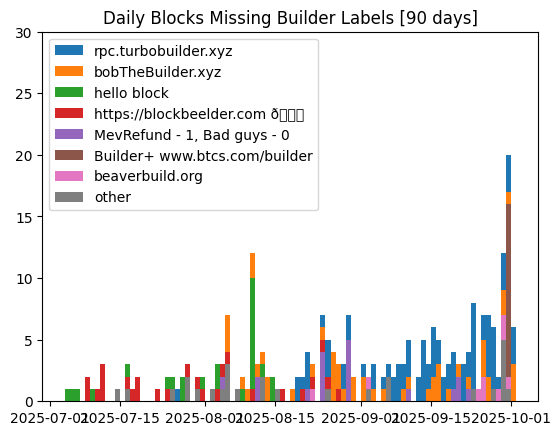

In [7]:
# Revove known anonymous builders --> no point in plotting things we can't address
reduced = df[df['extra_data_utf'] != '']
reduced = reduced[~reduced['extra_data_utf'].isin(['0x25', '0x26', '0x15', '0x46', '0x65', '0x45'])]

t1 = reduced[reduced['block_datetime'] > reduced['block_datetime'].max() - pd.Timedelta(90, 'd')]
builders = list(t1['extra_data_utf'].value_counts().head(7).index)
zz = resample_slots(t1, step_size='1D')
plt.fill_between(zz.index, zz.values, step='post', label = builders[0])

builders.append('other')

for xx in range(len(builders)-1):
    t1 = t1[t1['extra_data_utf'] != builders[xx]]
    zz = resample_slots(t1, step_size='1D')
    plt.fill_between(zz.index, zz.values, step='post', label = builders[xx+1])

plt.legend(loc = 'upper left')
plt.ylim(0, 30)
plt.title('Daily Blocks Missing Builder Labels [90 days]')
plt.show()

In [8]:
# The biggest unlabeled pubkeys from the past 10 days
reduced[reduced['block_datetime'] > reduced['block_datetime'].max() - pd.Timedelta(10, 'd')]['builder_pubkey'].value_counts()

builder_pubkey
0xb3a6dc1f159cd010d6d4999822337524576d9ef9d14f34dc7337a735f2d80cd4d64414da809661967df09f39320bc2df    23
0xb7c5beef142c8ff6440e4b7cf2b3efb8e4fbe3a76acf6ed20d69717a46adf9f8bbefb502828d7234a4d3fd03597bd601    14
0xba003e46bc0cf0c66bfc8197dc5996d04a62f232bee4addd7b91c0d2936e203627cc9973095c32acf34ff46bf76a4a62    12
0x880d88f5f183a858a08bb057110b98965beeaf38b1beaaedaac76f0e55d8ec341e4c6e549c19fa44574521ef3382444a     6
0xb3b03e65d5ca179e4e67e72aaa8b25f24c8b70d1fe5ad0f65d1375b6658f017ee0bc3db16a379f32733035ed2ac81ef7     6
0xa535fa195160a5b5812f04601edc1ddccfe2918773a74af915563779e448723ba841e8b46d446d96d91dc0ddc24edfbe     5
0x954e26a086a7101e500f93bfd1a78aab7c76eb8e2a8acc979e0f8426f0e7b216bdeabb0baf85bf542ff256b9b7dff0d2     3
0xad645a99eb5c574dc29ddbb414ce35d0b5c02ad4aa662c24bd906299e8284a5abf5b6bce9845ed338751cc17ac801bb4     2
0xa1102ce0db57892f58dde3385291f16bbcb13874c38740c86582cc1a4a69f9ed1e1716ee16270144da612bef4d7ad51d     2
0xa1a084d7081f2d470e264db84c16108abf9977

In [9]:
# check who they are
reduced[reduced['builder_pubkey'] == '0xb3a6dc1f159cd010d6d4999822337524576d9ef9d14f34dc7337a735f2d80cd4d64414da809661967df09f39320bc2df']['extra_data_utf'].value_counts()

extra_data_utf
rpc.turbobuilder.xyz    36
Name: count, dtype: int64

/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 144 (\x90) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tripoli/.local/share/virtualenvs/mev-boost-r8pQE99Q/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 156 (\x9c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


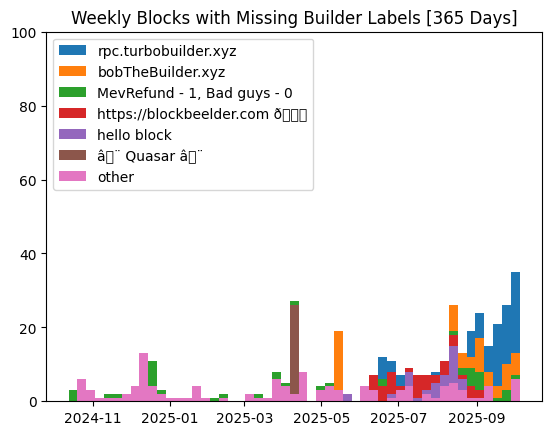

In [10]:
t1 = reduced[reduced['block_datetime'] > reduced['block_datetime'].max() - pd.Timedelta(365, 'd')]
builders = list(t1['extra_data_utf'].value_counts().head(6).index)
zz = resample_slots(t1, step_size='1W')
plt.fill_between(zz.index, zz.values, step='post', label = builders[0])

builders.append('other')

for xx in range(len(builders)-1):
    t1 = t1[t1['extra_data_utf'] != builders[xx]]
    zz = resample_slots(t1, step_size='1W')
    plt.fill_between(zz.index, zz.values, step='post', label = builders[xx+1])

plt.legend(loc = 'upper left')
plt.ylim(0, 100)
plt.title('Weekly Blocks with Missing Builder Labels [365 Days]')
plt.show()